In [1]:
%load_ext lab_black

# Gold recovery prediction
In this project, we are going to build a model, which will help to optimize the production gold production and eliminate unprofitable parameters. The model should predict the amount of gold recovered from gold ore. We have been provided the data on extraction and purification stages of gold.

**We need to predict two values:**
- rougher concentrate recovery `rougher.output.recovery`
- final concentrate recovery `final.output.recovery`


For these we will perform following steps:
- Prepare the data;
- Perform data analysis;
- Develop and train a model.


The data is stored in three files:
- /datasets/gold_recovery_train.csv
- /datasets/gold_recovery_test.csv
- /datasets/gold_recovery_full.csv

Data is indexed with the date and time of acquisition (`date` feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data.

### Data description
**Technological process**

- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

**Parameters of stages**
- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate


**Feature naming**
Here's how you name the features:
`[stage].[parameter_type].[parameter_name]`

Example: `rougher.input.feed_ag`:

*Possible values for* `[stage]`:
- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics


*Possible values for* `[parameter_type]`:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

## Data preparation

### Open the files and look into the data

In [2]:
# all required libraries should be imported here
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [5]:
# load datafiles and display first seevral line to familiarize with it
try:
    df_train = pd.read_csv(
        "gold_recovery_train.csv",
        parse_dates=True,
        infer_datetime_format=True,
        index_col="date",
    )
    display(df_train.head(2))
    df_test = pd.read_csv(
        "gold_recovery_test.csv",
        parse_dates=True,
        infer_datetime_format=True,
        index_col="date",
    )
    display(df_test.head(2))
    df_full = pd.read_csv(
        "gold_recovery_full.csv",
        parse_dates=True,
        infer_datetime_format=True,
        index_col="date",
    )
    display(df_full.head(2))
except:
    print("Make sure paths and files are correct!")

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


In [6]:
# datafiles look to large, let's get number of rows and columns in each of them
display(df_train.shape)
print("=" * 50)
display(df_test.shape)
print("=" * 50)
df_full.shape

(16860, 86)

(5856, 52)

(22716, 86)

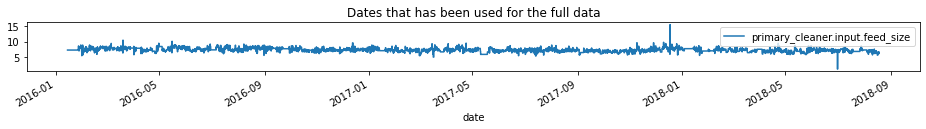

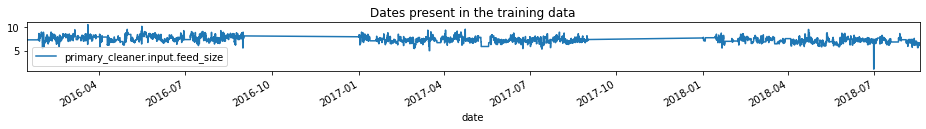

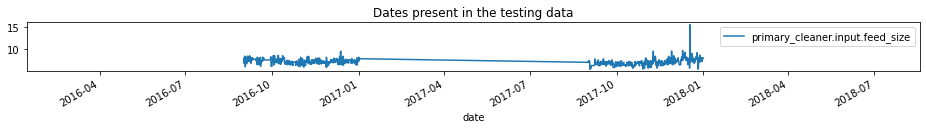

In [7]:
# we have been provided three data files, lets check what is their difference other than number of columns
df_full.plot(kind="line", y="primary_cleaner.input.feed_size", figsize=(16, 1))
plt.title("Dates that has been used for the full data")

df_train.plot(
    kind="line",
    y="primary_cleaner.input.feed_size",
    figsize=(16, 1),
    xlim=(df_full.index.min(), df_full.index.max()),
)
plt.title("Dates present in the training data")

df_test.plot(
    kind="line",
    y="primary_cleaner.input.feed_size",
    figsize=(16, 1),
    xlim=(df_full.index.min(), df_full.index.max()),
)
plt.title("Dates present in the testing data")

plt.show()

> Three data files have been provided. in order to understand the relationship between files (other than columns they contain), we have built line plots for a random column. Now it can be seen which dates were used for each dataset's preparation.

In [8]:
# calcualte number of missing values and their percentages in each columns of every data file
def missing_data(list_of_dfs, list_of_names):
    for i in range(len(list_of_dfs)):
        df = list_of_dfs[i]
        col_names = df.columns.tolist()
        na_per_col = df.isna().sum().tolist()
        na_percentage = (df.isna().sum() / len(df) * 100).tolist()
        print("=" * 20, "Missing values of", list_of_names[i], "=" * 20)
        display(
            pd.DataFrame(
                list(zip(na_per_col, na_percentage)),
                columns=["Number of missings", "% of missings"],
                index=col_names,
            ).style.background_gradient(axis=0)
        )


# apply the function
missing_data([df_train, df_test, df_full], ["df_train", "df_test", "df_full"])

==================== Missing values of df_train ====================


,Number of missings,% of missings
final.output.concentrate_ag,72,0.427046
final.output.concentrate_pb,72,0.427046
final.output.concentrate_sol,370,2.194543
final.output.concentrate_au,71,0.421115
final.output.recovery,1521,9.021352
final.output.tail_ag,66,0.391459
final.output.tail_pb,183,1.085409
final.output.tail_sol,145,0.860024
final.output.tail_au,66,0.391459
primary_cleaner.input.sulfate,1307,7.752076


==================== Missing values of df_test ====================


,Number of missings,% of missings
primary_cleaner.input.sulfate,302,5.157104
primary_cleaner.input.depressant,284,4.849727
primary_cleaner.input.feed_size,0,0.000000
primary_cleaner.input.xanthate,166,2.834699
primary_cleaner.state.floatbank8_a_air,16,0.273224
primary_cleaner.state.floatbank8_a_level,16,0.273224
primary_cleaner.state.floatbank8_b_air,16,0.273224
primary_cleaner.state.floatbank8_b_level,16,0.273224
primary_cleaner.state.floatbank8_c_air,16,0.273224
primary_cleaner.state.floatbank8_c_level,16,0.273224


==================== Missing values of df_full ====================


,Number of missings,% of missings
final.output.concentrate_ag,89,0.391794
final.output.concentrate_pb,87,0.382990
final.output.concentrate_sol,385,1.694841
final.output.concentrate_au,86,0.378588
final.output.recovery,1963,8.641486
final.output.tail_ag,83,0.365381
final.output.tail_pb,200,0.880437
final.output.tail_sol,271,1.192992
final.output.tail_au,81,0.356577
primary_cleaner.input.sulfate,1609,7.083113


### Check that recovery is calculated correctly. 
Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

<div>
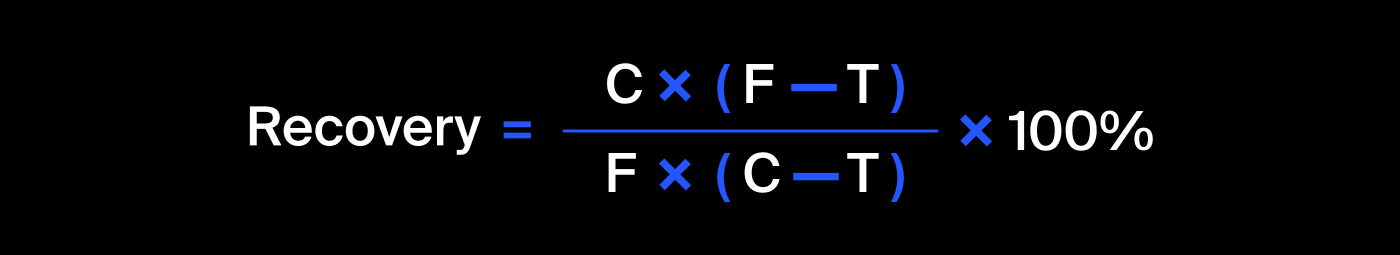
</div>

where:
- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [9]:
# a fucntion to calculate recovery
def recovery(c, f, t):
    prerecovery = (c * (f - t)) / (f * (c - t))
    recovery = prerecovery * 100
    recovery[recovery < 0] = np.nan
    recovery[recovery > 100] = np.nan
    return recovery


# prepare columns
c = df_train["rougher.output.concentrate_au"]
f = df_train["rougher.input.feed_au"]
t = df_train["rougher.output.tail_au"]

# apply the function
recovery_list = recovery(c, f, t)

MAE = mean_absolute_error(
    df_train["rougher.output.recovery"].fillna(0), recovery_list.fillna(0)
)
print(
    "Mean absolute error of calculated and provided recovery values is {:.3}".format(
        MAE
    )
)

Mean absolute error of calculated and provided recovery values is 7.88e-15


> MAE of calcualted and provided data is very very close to zero. That means, we don't need to worry about sanity, becasue the provided data was correctly done!

### Analyze the features not available in the test set. 
What are these parameters? What is their type?

In [10]:
# loop to find out which features are not existing in testing set
col_train = df_train.columns.tolist()
col_test = df_test.columns.tolist()

features_not_in_test = []
for x in col_train:
    if x not in col_test:
        features_not_in_test.append(x)

print("Following columns of training datasets were not present in testing dataset")
features_not_in_test

Following columns of training datasets were not present in testing dataset


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### Perform data preprocessing

As we have seen above, we have a lot of missing values in our datasets. We will fill all values using **mean** values of each column.

In [11]:
# prepare imputer for filling missing values
my_imptr = SimpleImputer()


# fit and fill missing values of training dataset using imputer
imp_df_train = pd.DataFrame(my_imptr.fit_transform(df_train))

# imputer removes column names and index, get them back
imp_df_train.columns = df_train.columns
imp_df_train.index = df_train.index


# use fitted imputer to fill missing values of source dataset
imp_df_full = pd.DataFrame(my_imptr.transform(df_full))
imp_df_full.columns = df_full.columns
imp_df_full.index = df_full.index

# get filled values for testing file from source
imp_df_test = imp_df_full.loc[df_test.index, df_test.columns]

### Conclusion

- 1.1 Three data files have been successfully loaded. The source file (`df_full`) has **22716 rows and 86 columns**. It was observed that the testing file (`df_test`) was obtained from two different time periods of the source file and `df_test` has **5856 rows, 52 columns**. The rest of the source file was used for the preparation of the training file (`df_train`) with **16860 rows, 86 columns**.

- 1.2 There were missing values in all datafiles, these missing values were filled using **mean values of training dataset**. 

- 1.3 Several columns were not present in the testing file, however, when we check these columns, we found that they were intentionally removed. Because these columns have values that will cause data leakage for our future models.

- 1.4 Moreover, to be sure, the recovery values were calculated correctly, we have check recovery values of the rougher stage and it was found that they were correct (MAE = 8e-15)

## Data analysis

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

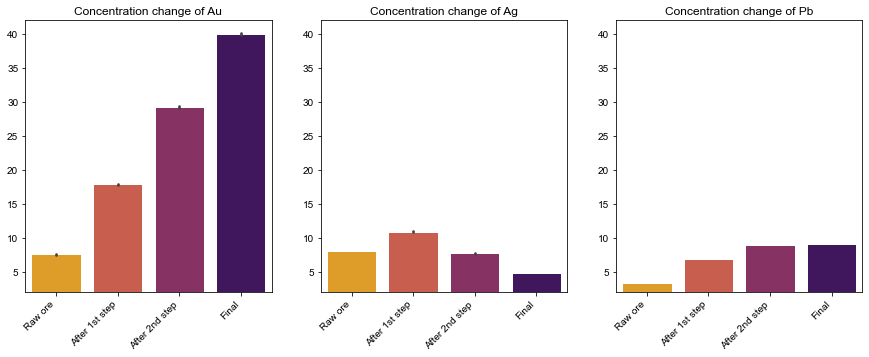

In [12]:
# columns showing each metals concentration at different stages

au_conc = [
    "rougher.input.feed_au",
    "rougher.output.concentrate_au",
    "primary_cleaner.output.concentrate_au",
    "final.output.concentrate_au",
]
ag_conc = [
    "rougher.input.feed_ag",
    "rougher.output.concentrate_ag",
    "primary_cleaner.output.concentrate_ag",
    "final.output.concentrate_ag",
]
pb_conc = [
    "rougher.input.feed_pb",
    "rougher.output.concentrate_pb",
    "primary_cleaner.output.concentrate_pb",
    "final.output.concentrate_pb",
]

# using a for loop, prepare bar charts for the change of concentration of every metal at each stage
metals = [au_conc, ag_conc, pb_conc]
titles = [
    "Concentration change of Au",
    "Concentration change of Ag",
    "Concentration change of Pb",
]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    sns.set_style("darkgrid")
    sns.barplot(data=imp_df_full[metals[i]], ax=ax[i], palette="inferno_r")
    ax[i].set_xticklabels(
        labels=["Raw ore", "After 1st step", "After 2nd step", "Final"],
        rotation=45,
        ha="right",
    )
    ax[i].set_ylim(2, 42)
    ax[i].set_title(titles[i])

### Compare the feed particle size distributions in the training set and in the test set. 
If the distributions vary significantly, the model evaluation will be incorrect.

C:\Users\Abdullayev.KERAMIK\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Abdullayev.KERAMIK\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


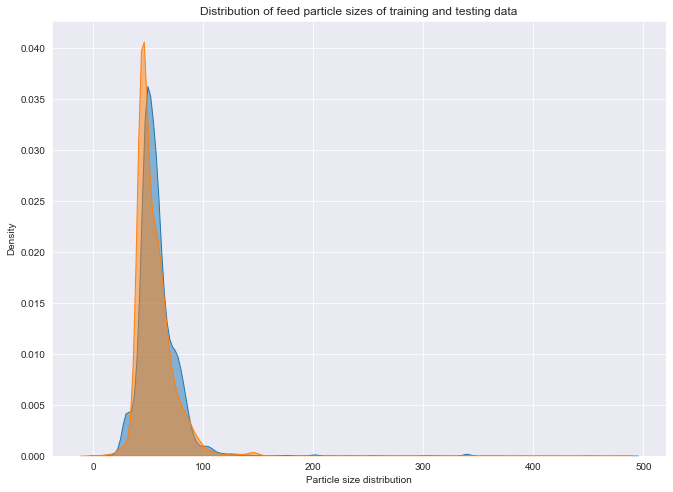

In [13]:
# get required columns to plot a hist
train_dst = imp_df_train["rougher.input.feed_size"]
test_dst = imp_df_test["rougher.input.feed_size"]

# plot a histogram (KDE) plots showing the particle size distribution of each dataset
plt.figure(figsize=(11, 8))
sns.distplot(
    train_dst,
    hist=False,
    kde_kws={"shade": True, "alpha": 0.5},
    label=(
        "Train \n mean: {:.3},\n median: {:.3}".format(
            train_dst.mean(), train_dst.median()
        )
    ),
)
sns.distplot(
    test_dst,
    hist=False,
    kde_kws={"shade": True, "alpha": 0.5},
    label=(
        "Test \n mean: {:.3},\n median: {:.3}".format(
            test_dst.mean(), test_dst.median()
        )
    ),
)

# customize the plots
plt.xlabel("Particle size distribution")
plt.ylabel("Density")
plt.title("Distribution of feed particle sizes of training and testing data")
plt.show()

> Mean particle size of training data is 58.7 and the mean particle size of testing data was 55.9. Even though, mean values differ a little bit, general distribution of particle sizes were similar for two datasets. 

### Consider the total concentrations of all substances at different stages: 
raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [14]:
# calcaulte the total concentration of substances (Au, Ag, Pb and sol) at each stage
# total concentration at raw feed
imp_df_full["total.conc.feed"] = imp_df_full[
    [
        "rougher.input.feed_au",
        "rougher.input.feed_ag",
        "rougher.input.feed_pb",
        "rougher.input.feed_sol",
    ]
].sum(axis=1)

# total conc at rougher output
imp_df_full["total.conc.rougher"] = imp_df_full[
    [
        "rougher.output.concentrate_ag",
        "rougher.output.concentrate_pb",
        "rougher.output.concentrate_sol",
        "rougher.output.concentrate_au",
    ]
].sum(axis=1)

# total conc at final output
imp_df_full["total.conc.final"] = imp_df_full[
    [
        "final.output.concentrate_ag",
        "final.output.concentrate_pb",
        "final.output.concentrate_sol",
        "final.output.concentrate_au",
    ]
].sum(axis=1)

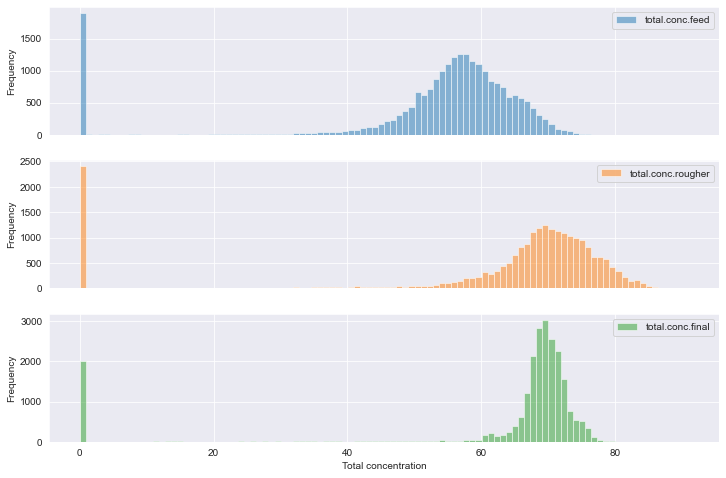

In [15]:
# plot histogram for each step
imp_df_full[["total.conc.feed", "total.conc.rougher", "total.conc.final"]].plot(
    kind="hist", alpha=0.5, bins=100, figsize=(12, 8), subplots=True
)
plt.xlabel("Total concentration")
plt.show()

> There are a lot of zero values in the data (the total.conc columns). That mean something is going wrong there. Maybe, these data was not recorded and then they just filled with zero. We can treat these values as missing values and can drop them! 

In [16]:
# get all rows when the total concentration is equal to zero
rows_with_problem = imp_df_full[
    (imp_df_full["total.conc.feed"] == 0)
    | (imp_df_full["total.conc.rougher"] == 0)
    | (imp_df_full["total.conc.final"] == 0)
].index

In [17]:
# check how many rows we need to drop from each  dataset, if want to drop all these rows

test_rows_to_drop = []
train_rows_to_drop = []

for ind in rows_with_problem:
    if ind in imp_df_test.index:
        test_rows_to_drop.append(ind)
    elif ind in imp_df_train.index:
        train_rows_to_drop.append(ind)

print(
    "Percentage of rows that are concidered for dropping in training data: {:.2%}".format(
        len(train_rows_to_drop) / len(imp_df_train)
    )
)
print(
    "Percentage of rows that are concidered for dropping in testing data: {:.2%}".format(
        len(test_rows_to_drop) / len(imp_df_test)
    )
)

Percentage of rows that are concidered for dropping in training data: 9.98%
Percentage of rows that are concidered for dropping in testing data: 9.60%


In [18]:
# drop all rows with total conc equal to 0
imp_df_train.drop(train_rows_to_drop, inplace=True)
imp_df_test.drop(test_rows_to_drop, inplace=True)

### Conclusion

- 2.1 It was observed that the concentration of gold (Au) increased at each stage of purification. In the final output stage, the concentration of gold reached around 40. Lead (Pb) also follows the same trend, however, the final concentration is just around 9. But, for the silver (Ag), the concentration increased first and then dropped, where at the final stage its concentration was around 5.

- 2.2 Particle size distribution of raw feed of training and testing data sets compared by visualizing density plots. It was observed that they have a similar distribution, even though their mean and median values differ slightly.

- 2.3 Finally we have checked the total concentration of substances at each stage and visualized their distribution. Surprisingly, it was found that there were a lot of rows with a total concentration equal to zero. For the sake of not putting more biases into our data, we decided to drop all rows (in training and testing datasets) when the total concentration is equal to zero. Consequently, ca. 10% of rows were dropped from training and testing datasets.

## Build the model

### Write a function to calculate the final sMAPE value.

In [19]:
# function to calcualte sMAPE score for predicted and actual values
def smaper(y, y_pred):
    smape = (
        1
        / len(y)
        * np.sum(np.abs(y - y_pred) * 2 * 100 / ((np.abs(y) + np.abs(y_pred))))
    )
    return smape


# convert it to sklearn function so it can be directly attached to CV scoring parameter
my_scorer = make_scorer(smaper, greater_is_better=False)

### Train different models. 
Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
Use these formulas for evaluation metrics:

<div>
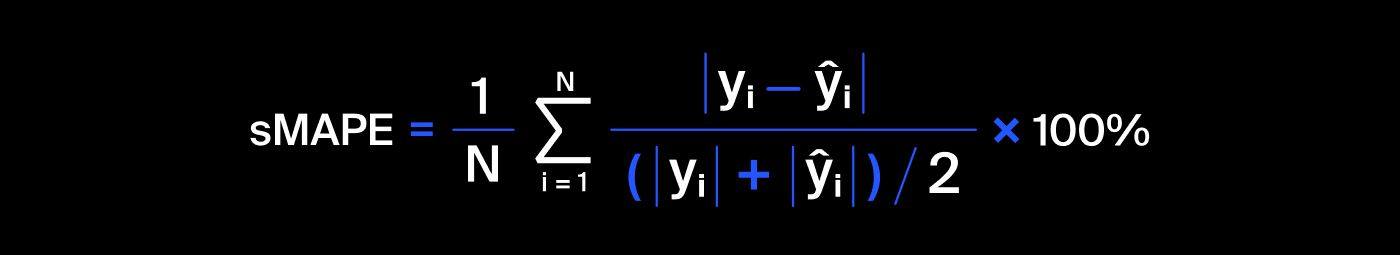 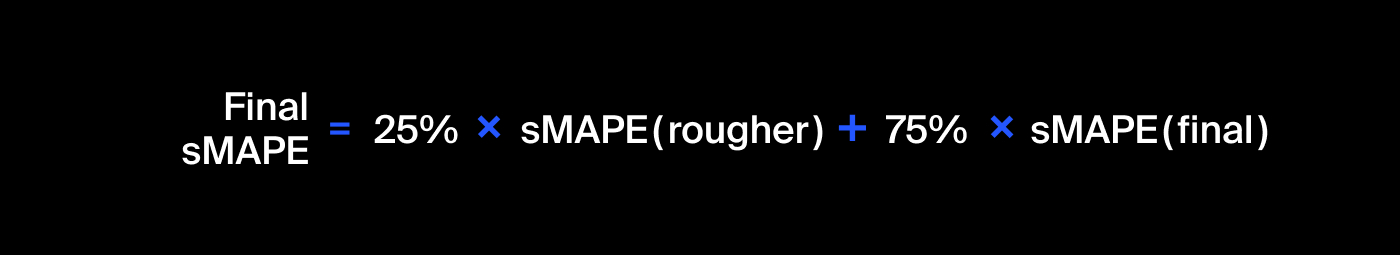
</div>

Here we will build a separate model for ``rougher.output`` and ``final.output`` stages to predict recovery values. Accordingly, we will prepare datasets for each stage, because we can not include all columns to rougher.output stage, due to that will be definitely data leakage.

In [20]:
# columns that will be required for final and rougher prediction models
features_final = df_test.columns.tolist()
features_rougher = [x for x in features_final if "rougher" in x.split(".")]

print(
    "Final output prediction model will have {} features to predict "
    "output recovery, while rougher output prediction model will have only {} features.".format(
        len(features_final), len(features_rougher)
    )
)

Final output prediction model will have 52 features to predict output recovery, while rougher output prediction model will have only 22 features.


> Nomenclature
- X - features dataframe
- y - target
- train - training datasets obtained from **df_train
- test - testing dataset obtained from **df_test
- r - datasets for **rougher.output.receovery** model
- f - datasets for **rougher.output.receovery** model

In [21]:
# datasets for final.output.recovery model
X_train_r = imp_df_train[features_rougher].reset_index(drop=True)
y_train_r = imp_df_train["rougher.output.recovery"].reset_index(drop=True)

X_test_r = imp_df_full.loc[df_test.index, features_rougher].reset_index(drop=True)
y_test_r = imp_df_full.loc[df_test.index, "rougher.output.recovery"].reset_index(
    drop=True
)


# datasets for final.output.recovery model
X_train_f = imp_df_train[features_final].reset_index(drop=True)
y_train_f = imp_df_train["final.output.recovery"].reset_index(drop=True)

X_test_f = imp_df_full.loc[df_test.index, features_final].reset_index(drop=True)
y_test_f = imp_df_full.loc[df_test.index, "final.output.recovery"].reset_index(
    drop=True
)

In [25]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from xgboost import XGBRegressor

In [26]:
# check different models to find out best model for rougher output prediction
# set the random value
state = RandomState(12345)


# construct a pipeline
pipeline = Pipeline([("scaler", StandardScaler()), ("model", RandomForestRegressor())])

# parameters need to be checkec (here we used only three different algorithms, because when we tune hyperparameteres it took so long)
params = [
    {
        "model": [
            RandomForestRegressor(n_estimators=10, max_depth=10, random_state=state)
        ]
    },
    {"model": [LinearRegression()]},
    {"model": [XGBRegressor()]},
]

# construct a grid to search best algorithm
grid_r = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1, scoring=my_scorer)

# train each model using 3 cross_validation steps
grid_r.fit(X_train_r, y_train_r)


# display results by ranking best to worst
results_r = pd.DataFrame(grid_r.cv_results_)
results_r = results_r.sort_values("rank_test_score")
results_r

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.015418,0.011464,0.015658,2.053856e-03,"RandomForestRegressor(max_depth=10, n_estimato...","{'model': RandomForestRegressor(max_depth=10, ...",-9.061248,-6.767759,-9.347498,-8.392168,1.154560,1
1,0.046638,0.025679,0.005995,8.778064e-07,LinearRegression(),{'model': LinearRegression()},-9.685131,-5.366044,-13.463916,-9.505030,3.308394,2
2,9.357138,0.380367,0.024341,3.331062e-03,"XGBRegressor(base_score=None, booster=None, co...","{'model': XGBRegressor(base_score=None, booste...",-9.161916,-8.347886,-13.054628,-10.188143,2.053974,3


In [27]:
# do the above steps for final output prediction
grid_f = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1, scoring=my_scorer)
grid_f.fit(X_train_f, y_train_f)
results_f = pd.DataFrame(grid_f.cv_results_)
results_f = results_f.sort_values("rank_test_score")
results_f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.197869,0.027657,0.026005,0.006677,"RandomForestRegressor(max_depth=10, n_estimato...","{'model': RandomForestRegressor(max_depth=10, ...",-9.711987,-10.447165,-15.623993,-11.927715,2.630839,1
2,20.666333,0.833574,0.042665,0.018728,"XGBRegressor(base_score=None, booster=None, co...","{'model': XGBRegressor(base_score=None, booste...",-13.662008,-11.456288,-17.491307,-14.203201,2.493328,2
1,0.090112,0.039453,0.018989,0.014846,LinearRegression(),{'model': LinearRegression()},-13.662168,-11.945212,-22.502770,-16.036717,4.625608,3


### Final model training and evaluation using test set
From above steps, we have found that RandomForestRegressor was performing best both in prediction of rougher output recovery and final output recovery. Therefore, we will chose RandomForestRegressor and build our final model for each stage.

In [28]:
# construct a model,  train it using whole training data for rougher stage, then predict output recovery of rougher stage
rougher_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=234)
rougher_model.fit(X_train_r, y_train_r)

# predicted values of rougher.output.recovery for testing dataset
y_test_r_pred = rougher_model.predict(X_test_r)


# construct a model,  train it using whole training data for final stage, then predict output recovery of final stage
final_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=234)
final_model.fit(X_train_f, y_train_f)

# predicted values of final.output.recovery for testing dataset
y_test_f_pred = final_model.predict(X_test_f)


# calculate the sMAPE score for each stage
smape_rougher = smaper(y_test_r, y_test_r_pred)
smape_final = smaper(y_test_f, y_test_f_pred)


print("sMAPE score for the rougher stage is: {:.3}".format(smape_rougher))
print("sMAPE score for the final stage is: {:.3}".format(smape_final))

# print out final sMAPE score
print(
    "Total sMAPE of the model is: {:.3}".format(
        0.25 * smape_rougher + 0.75 * smape_final
    )
)

sMAPE score for the rougher stage is: 8.57
sMAPE score for the final stage is: 11.6
Total sMAPE of the model is: 10.9


### Conclusion

- 3.1 Three different algorithms were tested (LinearRegression, RandomForestRegressor, and XGBregressor) using the cross_validation technique. Please note that hyperparameters were not tuned at this stage, becasue it will take too much time to train models and check the results. Therefore random hyperparameters, based on previous experience were chosen. 

- 3.2 RandomForestRegressor with 10 trees (n_estimators) and 10 as size of the tree (max_depth) were chosen as the best model with its sMAPE score for rougher and final output recoveries was equal to 9.08 and 11.66. respectively. 

- 3.3 The RandomForest model as described above was trained with the whole training dataset and tested with the testing dataset. Ultimately, the final sMAPE value is equal to 10.9!

## Summary

- 1.1 Three data files have been successfully loaded. The source file (`df_full`) has **22716 rows and 86 columns**. It was observed that the testing file (`df_test`) was obtained from two different time periods of the source file and `df_test` has **5856 rows, 52 columns**. The rest of the source file was used for the preparation of the training file (`df_train`) with **16860 rows, 86 columns**.

- 1.2 There were missing values in all data files, these missing values were filled using **mean values of training dataset**. 

- 1.3 Several columns were not present in the testing file, however, when we check these columns, we found that they were intentionally removed. Because these columns have values that will cause data leakage for our future models.



- 2.1 It was observed that the **concentration of gold (Au) increased at each stage of purification**. In the final output stage, the concentration of **gold reached around 40**. Lead (Pb) also follows the same trend, however, the final concentration is just around 9. But, for the silver (Ag), the concentration increased first and then dropped, where at the final stage its concentration was around 5.

- 2.2 **Particle size distribution of raw feed of training and testing** data sets compared by visualizing density plots. It was observed that they have a **similar distribution**, even though their mean and median values differ slightly.

- 2.3 Finally we have checked the total concentration of substances at each stage and visualized their distribution. Surprisingly, it was found that there were a lot of rows with a total concentration equal to zero. For the sake of not putting more biases into our data, we decided to **drop all rows (in training and testing datasets) when the total concentration is equal to zero**. Consequently, **ca. 10% of rows were dropped** from training and testing datasets.


- 3.1 Three different algorithms were tested (**LinearRegression, RandomForestRegressor, and XGBregressor) using the cross_validation technique**. 

- 3.2 **RandomForestRegressor** with 10 trees (n_estimators) and 10 as size of the tree (max_depth) were chosen as the **best model** with its sMAPE score for rougher and final output recoveries was equal to 9.08 and 11.66. respectively. 

- 3.3 **Ultimately, the final sMAPE value is equal to 10.9!**